In [69]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 917 kB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=a38a8fa038a3051bbe0bef78b080f7bba6409e223b0d48e29d817f967e857741
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
from plotnine import *
%matplotlib inline
from collections import Counter
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

from ipywidgets import Image
from io import StringIO
import graphviz
from sklearn.tree import export_graphviz

In [2]:
df = pd.read_csv('../input/amphibians-data-set/dataset.csv',delimiter=';')
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

# EDA

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
for feature in df.columns:
    print(feature,df[feature].isnull().sum(),'of',df.shape[0],'values are missing')

We have no missing values in our dataset.

Numerical Variables: ID, SR, NR, OR. <br>
Categorical Variables: all the rest. Some of them are ordinal.

In [3]:
numerical_variables = ['ID','SR','NR']
categorical_variables = list(set(df.columns)-set(numerical_variables))

In [ ]:
category2 = ["SUR1", "SUR2", "SUR3"]
for c in category2:
    print("{} \n".format(df[c].value_counts()))

In [4]:
ds = df.copy()  

In [ ]:
from plotnine import options
options.figure_size = (6,2)
for i in categorical_variables:
    ds[i] = sorted(ds[i])
    (print(   
            ggplot(ds)
            +aes(i,fill = 'Motorway')
            +geom_bar(width=0.3)
            +ggtitle(''))
    ) 

In [ ]:
ds.columns

In [5]:
species = ['Green frogs','Brown frogs','Common toad','Fire-bellied toad','Tree frog',\
    'Common newt','Great crested newt']
df['Species'] = df[species].astype(np.int).sum(axis=1)
df=df.drop(species, axis=1)

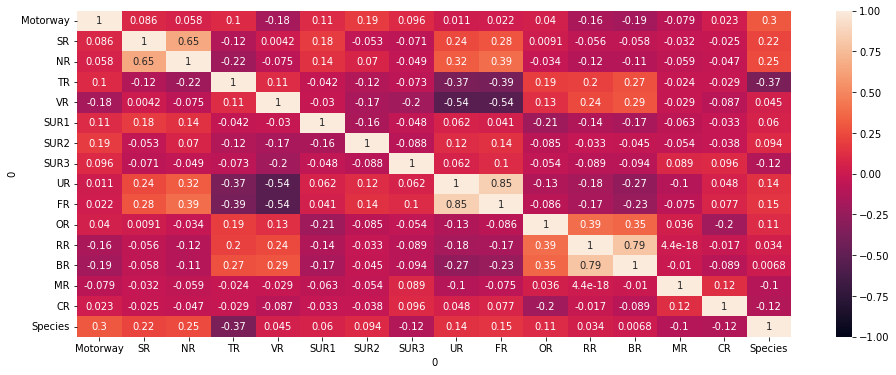

In [6]:
data_copy = df.copy()

data_copy['Motorway'] = data_copy['Motorway'].replace('A1', 1)
data_copy['Motorway'] = data_copy['Motorway'].replace('S52', 2)
data_copy = data_copy.apply(pd.to_numeric) 
data_copy = data_copy.drop(['ID'],axis=1)
plt.figure(figsize=(16, 6))
ax = sns.heatmap(data_copy.corr(),vmin=-1,vmax=1, annot=True)

- Highly positively correlated features:<br>NR and SR, FR and UR, RR and BR.
- Highly negatively correlated features:<br>UR and VR, FR and VR. 
- Species are weakly correlated with VR, SUR1, SUR2, RR, BR.

In [ ]:
df.head()

In [7]:
data = df.copy()

data['Motorway'] = data['Motorway'].replace('A1', 1)
data['Motorway'] = data['Motorway'].replace('S52', 2)

#ax = sns.heatmap(data, annot=True)

In [8]:
data = data.apply(pd.to_numeric) 

In [9]:
data = data.drop(['ID'],axis=1)

## Checking for outliers

In [10]:
def detect_outliers(df2,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df2[c],25)
        # 3rd quartile
        Q3 = np.percentile(df2[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5

        # detect outlier and their indeces
        outlier_list_col = df2[(df2[c] < Q1 - outlier_step) | \
                               (df2[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [11]:
df.loc[detect_outliers(data,data.columns)]

,ID,Motorway,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Species
47,47,A1,25000,5,1,0,2,9,7,3,4,75,0,0,0,1,2
63,63,A1,19300,2,1,1,2,6,1,3,3,75,2,0,0,1,5
97,97,S52,10000,4,1,0,10,2,6,0,1,75,0,0,0,1,3
103,103,S52,500000,9,1,3,10,6,2,3,3,75,1,1,0,1,7
156,156,S52,200,1,1,3,2,6,5,0,0,50,1,1,1,2,3


In [12]:
df.drop(detect_outliers(data,data.columns),inplace=True)

## Labelling categorical data

In [13]:
df2 = df.copy() #Using df2 to label encoding

In [14]:
for i in species:
    try:
        categorical_variables.remove(i)
    except:
        continue
categorical_variables.remove('Motorway')

In [15]:
df2[categorical_variables] = df[categorical_variables].astype('int')

In [16]:
df2['TR'].replace({1:'natural reservoirs', 2:'recently formed', 5:'technological',
                   7:'garden',11:'trenches', 12:'wet meadows', 14:'river valleys',
                   15:'small watercourses'}, inplace=True)
df2['VR'].replace({0:'no vegetation', 1:'patches at the edges', 2:'heavily overgrown',
                   3:'some part devoid of vegetation',4:'reservoirs completely overgrown'},\
                  inplace=True)
for i in ['SUR1','SUR2','SUR3']:
    df2[i].replace({1:'forest areas', 2:'meadows', 4:'gardens',
                   6:'industrial areas',10:'river valleys', 7:'orchards', 9:'roads',
                   14:'agricultural'}, inplace=True)
df2['UR'].replace({0:'unused', 1:'scenic', 3:'technological'}, inplace=True)
df2['FR'].replace({0:'lack', 1:'intense fishing', 2:'breeding reservoirs',\
                   3:'remove',4:'remove'}, inplace=True)
df2['OR'].replace({25:'poor access', 50:'low access', 75:'medium access',100:'large access',\
                   99:'remove',80:'remove'}, inplace=True)
df2['RR'].replace({0:'<50 m', 1:'50-100 m', 2:'100-200 m',5:'200-500 m',9:'500-1000 m',\
                   10:'>10000'}, inplace=True)
df2['BR'].replace({0:'<50 m', 1:'50-100 m', 2:'100-200 m',5:'200-500 m',9:'500-1000 m',\
                   10:'>10000'}, inplace=True)
df2['MR'].replace({0:'Clean', 1:'slightly littered', 2:'heavily littered'}, inplace=True)
df2['CR'].replace({1:'Natural', 2:'Concrete'}, inplace=True)

In [ ]:
df2.head()

In [17]:
df3 = pd.get_dummies(df2.drop(['ID','SR','NR','Species'],axis=1))
frames = [df2[['ID','SR','NR','Species']],df3]
df_res = pd.concat(frames,axis=1)

In [18]:
df_res.head()

,ID,SR,NR,Species,Motorway_A1,Motorway_S52,TR_garden,TR_natural reservoirs,TR_recently formed,TR_river valleys,...,BR_100-200 m,BR_200-500 m,BR_50-100 m,BR_500-1000 m,BR_<50 m,BR_>10000,MR_Clean,MR_heavily littered,CR_Concrete,CR_Natural
1,1,600,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1
2,2,700,1,3,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,3,200,1,3,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,4,300,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
5,5,600,2,5,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


Remake plotnine visualization

In [ ]:
#%%time
binary_data=df_res.loc[:,'TR_garden':]

for i, col in enumerate(binary_data.columns):
    #plt.figure(i,figsize=(6,4))
    #sns.countplot(x=col, hue=df_res['Species'] ,data=df_res, palette="rainbow")
    #plt.show()
    (print(   
            ggplot(df_res,aes(col,fill='Species'))
            #+aes(col,fill='Species',color='Species')
            #+geom_bar()
            #+facet_wrap('~Species')
            #+ggtitle(''))
            + geom_bar()
            + geom_text(
            aes(label=after_stat('count'),fill='Species'),
            stat='count',
            #nudge_y=0.125,
            va='bottom')
    )) 

In [ ]:
df_res.shape

In [19]:
numerical = df_res[["SR","NR","Species"]]
categorical=df_res.drop(["SR","ID","NR","Species"],axis=1)

scaler = StandardScaler()
numerical = pd.DataFrame(scaler.fit_transform(numerical))
numerical.columns = ["SR","NR","Species"]

In [20]:
df_new = pd.concat([df['ID'],numerical, categorical], axis=1, join='inner')

In [21]:
df_new.head()

,ID,SR,NR,Species,Motorway_A1,Motorway_S52,TR_garden,TR_natural reservoirs,TR_recently formed,TR_river valleys,...,BR_100-200 m,BR_200-500 m,BR_50-100 m,BR_500-1000 m,BR_<50 m,BR_>10000,MR_Clean,MR_heavily littered,CR_Concrete,CR_Natural
1,1,-0.209636,-0.346896,-0.046032,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1
2,2,-0.226593,-0.346896,-0.046032,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,3,-0.223202,-0.346896,-1.104763,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,4,-0.213028,0.354521,1.012699,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
5,5,-0.226593,-0.346896,-1.634128,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


In [22]:
binary_data=df_new.loc[:,'TR_garden':]

In [24]:
df[categorical_variables] = df[categorical_variables].astype('int')
df['SR'] = df['SR'].astype('int')
df['NR'] = df['NR'].astype('int')
data=df.drop(["ID"],axis=1)

In [ ]:
data.head()

<AxesSubplot:xlabel='0', ylabel='0'>

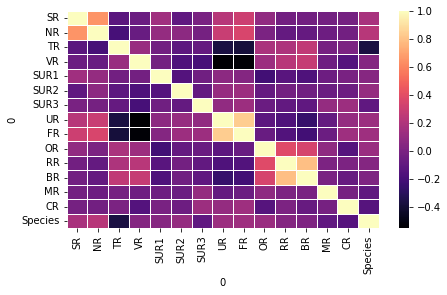

In [26]:
plt.figure(figsize=(7,4))
#sns.heatmap(data.corr())
sns.heatmap(data.corr(),cmap='magma',linecolor='white',annot=False,linewidths=1)

In [27]:
df_new = df_new.drop(["TR_garden","Motorway_A1","Motorway_S52","FR_remove",\
                   "OR_remove"],axis=1)

In [28]:
y=df_new['Species']
x=df_new.drop(["Species"],axis=1)
X=pd.DataFrame(x)

# Modelling

## XGBoost with Label Encoding

- df - for Label encoding
- df_new - one-hot encoding

In [30]:
df.head()

,ID,Motorway,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Species
1,1,A1,600,1,1,4,6,2,10,0,0,50,0,0,0,1,0
2,2,A1,700,1,5,1,10,6,10,3,1,75,1,1,0,1,3
3,3,A1,200,1,5,1,10,6,10,3,4,75,1,1,0,1,3
4,4,A1,300,1,5,0,6,10,2,3,4,25,0,0,0,1,1
5,5,A1,600,2,1,4,10,2,6,0,0,99,0,5,0,1,5


In [31]:
y = df["Species"]
x = df.drop(["Species","ID","Motorway"],axis=1)

In [32]:
x.head()

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR
1,600,1,1,4,6,2,10,0,0,50,0,0,0,1
2,700,1,5,1,10,6,10,3,1,75,1,1,0,1
3,200,1,5,1,10,6,10,3,4,75,1,1,0,1
4,300,1,5,0,6,10,2,3,4,25,0,0,0,1
5,600,2,1,4,10,2,6,0,0,99,0,5,0,1


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


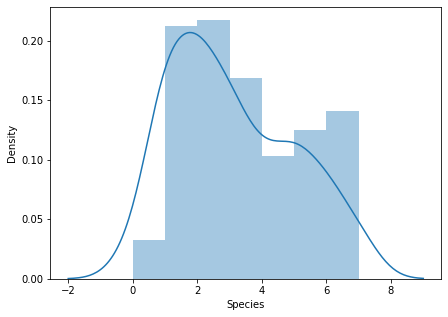

In [33]:
plt.figure(figsize=(7,5))
sns.distplot(y)
plt.show()

In [34]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [35]:
xgb = XGBRegressor().fit(x_train, y_train)

In [36]:
y_pred = xgb.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))

1.8810549053444434

RMSE = 1.8810549053444434

In [ ]:
xgb

In [37]:
xgb_grid = {
    'colsample_bytree': [0.4, 0.5, 0.6, 0.9 ,1],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.1, 0.01, 0.5]
}

In [ ]:
xgb = XGBRegressor()
xgb_cv = GridSearchCV(xgb, 
                     param_grid = xgb_grid,
                     cv=10,
                     n_jobs = -1,
                     verbose = 2)
xgb_cv.fit(x_train, y_train)

In [38]:
xgb_cv.best_params_

NameError: name 'xgb_cv' is not defined

In [39]:
xgb_tuned = XGBRegressor(colsample_bytree = 0.4,
                         learning_rate = 0.01,
                         max_depth = 2,
                         n_estimators = 500)
xgb_tuned = xgb_tuned.fit(x_train, y_train)

In [40]:
y_pred = xgb_tuned.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))

1.5419139624348617

RMSE = 1.5419139624348617

In [41]:
Importance=pd.DataFrame({"Importance":xgb_tuned.feature_importances_*100},
                       index = x_train.columns)

In [47]:
Importance

,Importance
0,
SR,8.087725
NR,8.695069
TR,16.275967
VR,7.523173
SUR1,6.033762
SUR2,6.006928
SUR3,5.862197
UR,2.942034
FR,7.915787


Text(0.5, 0, 'Importance level of values')

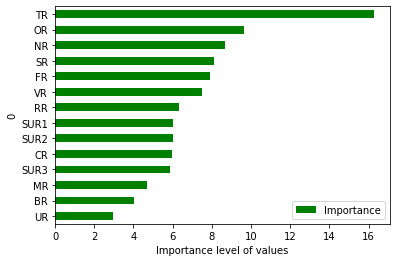

In [48]:
Importance.sort_values(by="Importance",
                      axis=0,
                      ascending=True).plot(kind="barh",color="green")
plt.xlabel("Importance level of values")

Type of water reservoirs **(TR)** is the most significant feature. Far from it are percentage access from the edges of the reservoir to undeveloped areas **(OR)** and number of water reservoirs in habitat **(NR)**.

In [51]:
model=sm.OLS(xgb_tuned.predict(x_test), x_test)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     8.580
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           5.32e-06
Time:                        19:49:21   Log-Likelihood:                -10.538
No. Observations:                  37   AIC:                             49.08
Df Residuals:                      23   BIC:                             71.63
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SR          1.282e-05   6.56e-06      1.953      0.063   -7.62e-07    2.64e-05
NR             0.1608      0.133      1.207      0.240      -0.115       0.436
TR            -0.1176      0.016     -7.407      0.000      -0.150      -0.085
VR             0.0757      0.072      1.051      0.304      -0.073       0.225
SUR1           0.0374      0.030      1.242      0.227      -0.025       0.100
SUR2           0.0173      0.026      0.664      0.513      -0.037       0.071
SUR3          -0.0221      0.029     -0.769      0.450      -0.081       0.037
UR            -0.1542      0.154     -1.004      0.326      -0.472       0.164
FR             0.1464      0.149      0.982      0.336      -0.162       0.455
OR             0.0040      0.006      0.637      0.530      -0.009       0.017
RR             0.0208      0.051      0.405      0.689      -0.085       0.127
BR             0.0808      0.042      1.916      0.068      -0.006       0.168
MR            -0.3039      0.229     -1.330      0.197      -0.777       0.169
CR             2.4382      0.863      2.826      0.010       0.653       4.223
==============================================================================
Omnibus:                       10.440   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               15.361
Skew:                           0.644   Prob(JB):                     0.000462
Kurtosis:                       5.882   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Random Forest

### Label Encoding

In [52]:
df.head()

,ID,Motorway,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Species
1,1,A1,600,1,1,4,6,2,10,0,0,50,0,0,0,1,0
2,2,A1,700,1,5,1,10,6,10,3,1,75,1,1,0,1,3
3,3,A1,200,1,5,1,10,6,10,3,4,75,1,1,0,1,3
4,4,A1,300,1,5,0,6,10,2,3,4,25,0,0,0,1,1
5,5,A1,600,2,1,4,10,2,6,0,0,99,0,5,0,1,5


In [54]:
x.head()

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR
1,600,1,1,4,6,2,10,0,0,50,0,0,0,1
2,700,1,5,1,10,6,10,3,1,75,1,1,0,1
3,200,1,5,1,10,6,10,3,4,75,1,1,0,1
4,300,1,5,0,6,10,2,3,4,25,0,0,0,1
5,600,2,1,4,10,2,6,0,0,99,0,5,0,1


In [61]:
rf = RandomForestRegressor(n_estimators=100,max_depth=3,random_state=42)
rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=3, random_state=42)

In [62]:
mae = mean_absolute_error(rf.predict(x_test),y_test)
mse = mean_squared_error(rf.predict(x_test),y_test)
rmse = np.sqrt(mse)

print("mean absolute error: %.2f" % mae)
print("mean squared error: %.2f" % mse)
print("root mean squared error: %.2f" % rmse)

mean absolute error: 1.31
mean squared error: 2.49
root mean squared error: 1.58


- mean absolute error: 1.31
- mean squared error: 2.49
- root mean squared error: 1.58

In [80]:
d_tree99 = rf.estimators_[99]    #estimator №100
dot_data = StringIO()
export_graphviz(d_tree99, feature_names = x.columns,
               out_file = dot_data, filled = True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value = graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05H\x00\x00\x01\xf1\x08\x02\x00\x00\x000j\xc1[\x00\…

In [83]:
rf_params = {"max_depth":[2,5,8,10],
             "max_features":[2,5,8],
             "n_estimators":[10,500,1000],
             "min_samples_split":[2,5,10]}

In [86]:
rf_model = RandomForestRegressor()
rf_cv_model = GridSearchCV(rf_model,         #hyperparameter tuning
                        rf_params,
                        cv=10,       # number of folds
                        n_jobs=-1,   #``-1`` means using all processors
                        verbose=2)   #Controls the verbosity: the higher, the more messages.

In [87]:
rf_cv_model.fit(x_train,y_train)
print("Best parameters: " + str(rf_cv_model.best_params_))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   52.5s


[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=500 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=500, total=   1.3s
[CV] max_depth=2, max_features=2, min_sample

KeyboardInterrupt: 

In [88]:
rf_tuned = RandomForestRegressor(max_depth=10,
                                  max_features=8,
                                  min_samples_split=10,
                                  n_estimators=1000)
rf_tuned.fit(x_train,y_train)

RandomForestRegressor(max_depth=10, max_features=8, min_samples_split=10,
                      n_estimators=1000)

In [89]:
mae=mean_absolute_error(rf_tuned.predict(x_test),y_test)
mse=mean_squared_error(rf_tuned.predict(x_test),y_test)
rmse=np.sqrt(mse)

print("mean_absolute_error: %.2f"%mae)
print("mean squared error: %.2f" %mse)
print("root mean squared error: %.2f" %rmse)

mean_absolute_error: 1.27
mean squared error: 2.42
root mean squared error: 1.56


- mean_absolute_error: 1.27
- mean squared error: 2.42
- root mean squared error: 1.56

In [93]:
print(r2_score(y_test,rf_tuned.predict(x_test)))

0.13692370922044717


R-squared is 0.1369.

In [94]:
Importance=pd.DataFrame({"Importance":rf_tuned.feature_importances_*100},
                       index=x_train.columns)

Text(0.5, 0, 'Importance level of values')

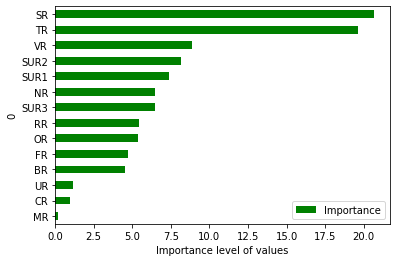

In [95]:
Importance.sort_values(by="Importance",
                      axis=0,
                      ascending=True).plot(kind="barh",color="green")
plt.xlabel("Importance level of values")

Surface of water reservoir **(SR)** is the most significant feature. Not far from it is the type of water reservoir **(TR)**.

In [97]:
model2=sm.OLS(rf_tuned.predict(x_test),x_test)
model2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     13.83
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           6.66e-08
Time:                        20:53:42   Log-Likelihood:                -4.9067
No. Observations:                  37   AIC:                             37.81
Df Residuals:                      23   BIC:                             60.37
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SR          1.722e-05   5.64e-06      3.054      0.006    5.56e-06    2.89e-05
NR             0.0736      0.114      0.643      0.526      -0.163       0.310
TR            -0.1164      0.014     -8.532      0.000      -0.145      -0.088
VR             0.0820      0.062      1.326      0.198      -0.046       0.210
SUR1           0.0516      0.026      1.992      0.058      -0.002       0.105
SUR2           0.0867      0.022      3.873      0.001       0.040       0.133
SUR3          -0.0020      0.025     -0.083      0.935      -0.053       0.049
UR             0.0614      0.132      0.466      0.646      -0.211       0.334
FR            -0.0794      0.128     -0.620      0.541      -0.344       0.186
OR             0.0051      0.005      0.949      0.352      -0.006       0.016
RR            -0.0387      0.044     -0.878      0.389      -0.130       0.052
BR             0.1442      0.036      3.982      0.001       0.069       0.219
MR            -0.3157      0.196     -1.609      0.121      -0.722       0.090
CR             1.9572      0.741      2.641      0.015       0.424       3.490
==============================================================================
Omnibus:                        1.276   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.528   Jarque-Bera (JB):                0.428
Skew:                           0.075   Prob(JB):                        0.807
Kurtosis:                       3.505   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### One-Hot Encoding

In [114]:
y=df_new['Species']
x=df_new.drop(["Species",'ID'],axis=1)
X=pd.DataFrame(x)

In [115]:
X.head()

,SR,NR,TR_natural reservoirs,TR_recently formed,TR_river valleys,TR_small watercourses,TR_technological,TR_trenches,TR_wet meadows,VR_heavily overgrown,...,BR_100-200 m,BR_200-500 m,BR_50-100 m,BR_500-1000 m,BR_<50 m,BR_>10000,MR_Clean,MR_heavily littered,CR_Concrete,CR_Natural
1,-0.209636,-0.346896,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,-0.226593,-0.346896,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,-0.223202,-0.346896,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,-0.213028,0.354521,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
5,-0.226593,-0.346896,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [116]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [117]:
rf2=RandomForestRegressor(n_estimators=100,max_depth=3,random_state=42)
rf2.fit(X_train,y_train)

RandomForestRegressor(max_depth=3, random_state=42)

In [118]:
mae = mean_absolute_error(rf2.predict(X_test),y_test)
mse = mean_squared_error(rf2.predict(X_test),y_test)
rmse = np.sqrt(mse)

print("mean absolute error: %.2f" % mae)
print("mean squared error: %.2f" % mse)
print("root mean squared error: %.2f" % rmse)

mean absolute error: 0.84
mean squared error: 1.10
root mean squared error: 1.05


- mean absolute error: 0.84
- mean squared error: 1.10
- root mean squared error: 1.05

In [119]:
d_tree99 = rf2.estimators_[99]
dot_data = StringIO()
export_graphviz(d_tree99, feature_names = X.columns,
               out_file = dot_data, filled = True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value = graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x96\x00\x00\x01\xf1\x08\x02\x00\x00\x00q\xb2~\xa…

In [105]:
rf2_params = {"max_depth":[2,5,8,10],
             "max_features":[2,5,8],
             "n_estimators":[10,500,1000],
             "min_samples_split":[2,5,10]}

In [106]:
rf2_model = RandomForestRegressor()
rf2_cv_model = GridSearchCV(rf2_model,
                        rf2_params,
                        cv=10,
                        n_jobs=-1,
                        verbose=2)


In [107]:
rf2_cv_model.fit(X_train,y_train)
print("Best parameters: " + str(rf2_cv_model.best_params_))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [120]:
rf2_tuned = RandomForestRegressor(max_depth=8,
                                  max_features=5,
                                  min_samples_split=5,
                                  n_estimators=10)
rf2_tuned.fit(X_train,y_train)

RandomForestRegressor(max_depth=8, max_features=5, min_samples_split=5,
                      n_estimators=10)

In [121]:
mae = mean_absolute_error(rf2_tuned.predict(X_test),y_test)
mse = mean_squared_error(rf2_tuned.predict(X_test),y_test)
rmse = np.sqrt(mse)

print("mean absolute error: %.2f" % mae)
print("mean squared error: %.2f" % mse)
print("root mean squared error: %.2f" % rmse)

mean absolute error: 0.80
mean squared error: 1.05
root mean squared error: 1.02


- mean absolute error: 0.80
- mean squared error: 1.05
- root mean squared error: 1.02

In [122]:
Importance=pd.DataFrame({"Importance":rf2_tuned.feature_importances_*100},
                       index=X_train.columns)

Text(0.5, 0, 'Importance level of values')

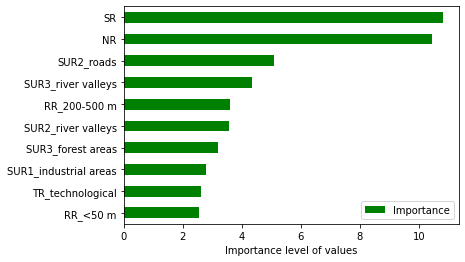

In [125]:
Importance.sort_values(by="Importance",
                      axis=0,
                      ascending=True).tail(10).plot(kind="barh",color="green")
plt.xlabel("Importance level of values")

Surface of water reservoir **(SR)** is the most significant feature. Number of water reservoirs in habitat **(NR)** is the second.

In [127]:
## from sklearn.metrics import r2_score
print(r2_score(y_test,rf2_tuned.predict(X_test)))

-0.13919969306667346


In [131]:
model=sm.OLS(rf2_tuned.predict(X_test),X_test)
model.fit().summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1729: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1452: RuntimeWarning: invalid value encountered in multiply


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 09 Dec 2021   Prob (F-statistic):                nan
Time:                        21:18:40   Log-Likelihood:                 1186.2
No. Observations:                  36   AIC:                            -2300.
Df Residuals:                       0   BIC:                            -2243.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
SR                                     0.2705        inf          0        nan         nan         nan
NR                                     0.0521        inf          0        nan         nan         nan
TR_natural reservoirs                 -0.0223        inf         -0        nan         nan         nan
TR_recently formed                     0.2872        inf          0        nan         nan         nan
TR_river valleys                      -0.5956        inf         -0        nan         nan         nan
TR_small watercourses                  0.3785        inf          0        nan         nan         nan
TR_technological                    2.146e-16        inf          0        nan         nan         nan
TR_trenches                           -0.1862        inf         -0        nan         nan         nan
TR_wet meadows                         0.0781        inf          0        nan         nan         nan
VR_heavily overgrown                   0.2543        inf          0        nan         nan         nan
VR_no vegetation                       0.0353        inf          0        nan         nan         nan
VR_patches at the edges               -0.0095        inf         -0        nan         nan         nan
VR_reservoirs completely overgrown    -0.3968        inf         -0        nan         nan         nan
VR_some part devoid of vegetation      0.0565        inf          0        nan         nan         nan
SUR1_agricultural                  -7.884e-17        inf         -0        nan         nan         nan
SUR1_forest areas                      0.1731        inf          0        nan         nan         nan
SUR1_gardens                        4.875e-16        inf          0        nan         nan         nan
SUR1_industrial areas                 -0.2803        inf         -0        nan         nan         nan
SUR1_meadows                           0.1181        inf          0        nan         nan         nan
SUR1_orchards                          0.0558        inf          0        nan         nan         nan
SUR1_river valleys                    -0.1270        inf         -0        nan         nan         nan
SUR1_roads                          4.833e-16        inf          0        nan         nan         nan
SUR2_11                            -1.379e-16        inf         -0        nan         nan         nan
SUR2_forest areas                     -0.4287        inf         -0        nan         nan         nan
SUR2_industrial areas                  0.2360        inf          0        nan         nan         nan
SUR2_meadows                          -0.1217        inf         -0        nan         nan         nan
SUR2_orchards                          0.1175        inf          0        nan         nan      

## Gradient Boosting

### One-Hot Encoding

In [134]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [135]:
y_pred = gbm_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

1.2027520112936811

RMSE = 1.203

In [137]:
gbm_params = {
    "learning_rate": [0.01, 0.1, 0.2],
    'max_depth': [3,5,8,50,100],
    'n_estimators': [200, 500, 1000, 2000],
    'subsample': [1, 0.5, 0.75],
}

In [138]:
gbm = GradientBoostingRegressor()
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv=10, n_jobs = -1, verbose =2)
gbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.5s


KeyboardInterrupt: 

In [ ]:
gbm_cv_model.best_params_

In [139]:
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.01,
                                      max_depth = 5,
                                      n_estimators = 200,
                                      subsample = 0.5)
gbm_tuned = gbm_tuned.fit(X_train, y_train)

In [140]:
y_pred = gbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

1.0889845691744988

RMSE = 1.089

In [141]:
Importance=pd.DataFrame({"Importance":gbm_tuned.feature_importances_*100},
                       index= X_train.columns)

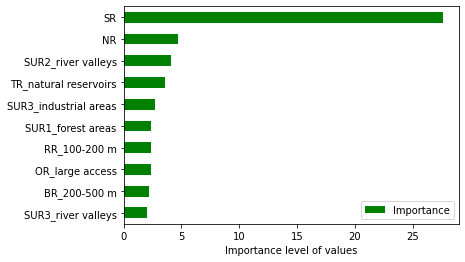

In [142]:
Importance.sort_values(by="Importance",
                      axis=0,
                      ascending=True).tail(10).plot(kind="barh",color="green")
plt.xlabel("Importance level of values")
plt.show()

Surface of water reservoir (**SR**) is the most significant feature. 

In [145]:
## from sklearn.metrics import r2_score
print(r2_score(y_test,gbm_tuned.predict(X_test)))

-0.28865196674689786


In [143]:
model=sm.OLS(gbm_tuned.predict(X_test),X_test)
model.fit().summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1729: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1452: RuntimeWarning: invalid value encountered in multiply


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 09 Dec 2021   Prob (F-statistic):                nan
Time:                        21:36:35   Log-Likelihood:                 1162.0
No. Observations:                  36   AIC:                            -2252.
Df Residuals:                       0   BIC:                            -2195.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
SR                                     0.5475        inf          0        nan         nan         nan
NR                                     0.2571        inf          0        nan         nan         nan
TR_natural reservoirs                  0.1150        inf          0        nan         nan         nan
TR_recently formed                    -0.4000        inf         -0        nan         nan         nan
TR_river valleys                      -0.1149        inf         -0        nan         nan         nan
TR_small watercourses                 -0.3586        inf         -0        nan         nan         nan
TR_technological                    5.197e-16        inf          0        nan         nan         nan
TR_trenches                            0.7991        inf          0        nan         nan         nan
TR_wet meadows                        -0.0253        inf         -0        nan         nan         nan
VR_heavily overgrown                  -0.2769        inf         -0        nan         nan         nan
VR_no vegetation                      -0.2333        inf         -0        nan         nan         nan
VR_patches at the edges                0.3340        inf          0        nan         nan         nan
VR_reservoirs completely overgrown     0.3063        inf          0        nan         nan         nan
VR_some part devoid of vegetation     -0.1149        inf         -0        nan         nan         nan
SUR1_agricultural                  -3.126e-16        inf         -0        nan         nan         nan
SUR1_forest areas                      0.1112        inf          0        nan         nan         nan
SUR1_gardens                       -9.285e-16        inf         -0        nan         nan         nan
SUR1_industrial areas                  0.2463        inf          0        nan         nan         nan
SUR1_meadows                          -0.0936        inf         -0        nan         nan         nan
SUR1_orchards                          0.0708        inf          0        nan         nan         nan
SUR1_river valleys                    -0.3195        inf         -0        nan         nan         nan
SUR1_roads                         -8.139e-16        inf         -0        nan         nan         nan
SUR2_11                             2.484e-16        inf          0        nan         nan         nan
SUR2_forest areas                      0.4881        inf          0        nan         nan         nan
SUR2_industrial areas                 -0.4823        inf         -0        nan         nan         nan
SUR2_meadows                           0.0353        inf          0        nan         nan         nan
SUR2_orchards                          0.3961        inf          0        nan         nan      

### Label Encoding

In [146]:
y = df["Species"]
x = df.drop(["Species","ID","Motorway"],axis=1)
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [148]:
gbm_model2 = GradientBoostingRegressor()
gbm_model2.fit(x_train, y_train)

GradientBoostingRegressor()

In [149]:
y_pred2 = gbm_model2.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred2))

1.7189063121093195

RMSE = 1.719

In [150]:
gbm_params = {
    "learning_rate": [0.01, 0.1, 0.2],
    'max_depth': [3,5,8,50,100],
    'n_estimators': [200, 500, 1000, 2000],
    'subsample': [1, 0.5, 0.75],
}

In [151]:
gbm2 = GradientBoostingRegressor()
gbm_cv_model2 = GridSearchCV(gbm2, gbm_params, cv=10, n_jobs = -1, verbose =2)
gbm_cv_model2.fit(x_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.0s


KeyboardInterrupt: 

In [ ]:
gbm_cv_model2.best_params_

In [152]:
gbm_tuned2 = GradientBoostingRegressor(learning_rate = 0.01,
                                      max_depth = 3,
                                      n_estimators = 200,
                                      subsample = 0.5)
gbm_tuned2 = gbm_tuned2.fit(x_train, y_train)

In [153]:
y_pred2 = gbm_tuned2.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred2))

1.5542415978125603

RMSE = 1.554

In [154]:
Importance=pd.DataFrame({"Importance":gbm_tuned2.feature_importances_*100},
                       index=x_train.columns)

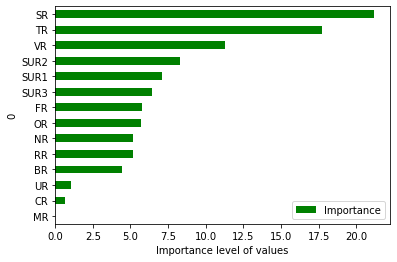

In [155]:
Importance.sort_values(by="Importance",
                      axis=0,
                      ascending=True).plot(kind="barh",color="green")
plt.xlabel("Importance level of values")
plt.show()

Surface of water reservoir (**SR**) is the most significant feature. Not far from it is the type of water reservoir (**TR**).

In [156]:
model2=sm.OLS(gbm_tuned2.predict(x_test), x_test)
model2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     9.573
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.03e-06
Time:                        21:43:54   Log-Likelihood:                -7.0862
No. Observations:                  37   AIC:                             42.17
Df Residuals:                      23   BIC:                             64.73
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SR          1.186e-05   5.98e-06      1.984      0.059   -5.09e-07    2.42e-05
NR             0.1319      0.121      1.086      0.289      -0.119       0.383
TR            -0.1118      0.014     -7.730      0.000      -0.142      -0.082
VR             0.0537      0.066      0.818      0.422      -0.082       0.189
SUR1           0.0538      0.027      1.961      0.062      -0.003       0.111
SUR2           0.0725      0.024      3.056      0.006       0.023       0.122
SUR3          -0.0356      0.026     -1.363      0.186      -0.090       0.018
UR            -0.0707      0.140     -0.506      0.618      -0.360       0.219
FR            -0.0135      0.136     -0.099      0.922      -0.295       0.267
OR             0.0077      0.006      1.343      0.193      -0.004       0.019
RR            -0.0422      0.047     -0.902      0.376      -0.139       0.055
BR             0.1233      0.038      3.210      0.004       0.044       0.203
MR            -0.2471      0.208     -1.187      0.247      -0.678       0.184
CR             2.0453      0.786      2.602      0.016       0.420       3.671
==============================================================================
Omnibus:                        4.480   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                3.363
Skew:                           0.433   Prob(JB):                        0.186
Kurtosis:                       4.196   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""